In [0]:
from IPython.display import clear_output
from random import shuffle
import time

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf

In [0]:
print(tf.__version__)

2.0.0


In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import norm

from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras.datasets import fashion_mnist

In [0]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

TPU address is grpc://10.27.139.178:8470


In [0]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


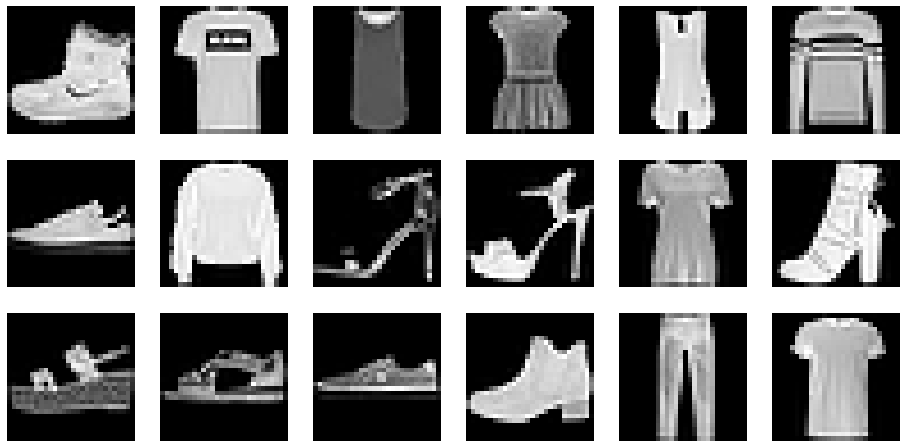

In [0]:
plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.show()

In [0]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [0]:
x_train_standard = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_standard = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train_standard.shape, x_test_standard.shape

((60000, 784), (10000, 784))

In [0]:
original_dim = 784
seed_dim = 8
intermediate_dim = 256
batch_size = 8

In [0]:
def adam_optimizer():
    return tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [0]:
def create_generator() -> tf.keras.Model:
    generator_input = tf.keras.layers.Input(shape=(seed_dim,))
    x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(generator_input)
    x = tf.keras.layers.Conv2DTranspose(1, 4, strides=2)(tf.reshape(x, shape=(-1, 16, 16, 1)))
    x = tf.nn.sigmoid(x)
    x = tf.keras.layers.Conv2D(1, 7, strides=1)(x)
    x = tf.nn.sigmoid(tf.reshape(x, shape=(-1, original_dim)))
    model = Model(
        inputs=generator_input,
        outputs=x,
        name="generator"
        )
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return model

def create_generator():
  generator=tf.keras.models.Sequential()
  generator.add(tf.keras.layers.Dense(units=256,input_dim=seed_dim))
  generator.add(tf.keras.layers.LeakyReLU(0.2))
  
  generator.add(tf.keras.layers.Dense(units=512))
  generator.add(tf.keras.layers.LeakyReLU(0.2))
  
  generator.add(tf.keras.layers.Dense(units=1024))
  generator.add(tf.keras.layers.LeakyReLU(0.2))
  
  generator.add(tf.keras.layers.Dense(units=original_dim, activation='tanh'))
  
  generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
  return generator

In [0]:
generator = create_generator()
print(generator.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

In [0]:
def create_discriminator() -> tf.keras.Model:
    discriminator_input = tf.keras.layers.Input(shape=(original_dim,))
    hidden = tf.keras.layers.Dense(intermediate_dim, activation='relu')(discriminator_input)
    hidden = tf.keras.layers.Dense(10, activation='relu')(hidden)
    discriminator_output = tf.keras.layers.Dense(1)(hidden)
    model = Model(inputs=discriminator_input, 
                 outputs=discriminator_output,
                 name="discriminator")
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
    return model


def create_discriminator():
    discriminator=tf.keras.models.Sequential()
    discriminator.add(tf.keras.layers.Dense(units=1024,input_dim=original_dim))
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    discriminator.add(tf.keras.layers.Dropout(0.3))
       
    
    discriminator.add(tf.keras.layers.Dense(units=512))
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    discriminator.add(tf.keras.layers.Dropout(0.3))
       
    discriminator.add(tf.keras.layers.Dense(units=256))
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    
    discriminator.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

In [0]:
discriminator = create_discriminator()
print(discriminator.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [0]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(seed_dim,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(discriminator, generator)
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1462800   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,923,025
Trainable params: 1,462,800
Non-trainable params: 1,460,225
_________________________________________________________________


In [0]:
def generate_and_plot(generator, inputs=None):
    
    if inputs is None:
      real_images = x_train[:8].reshape(-1, original_dim)
    else:
      real_images = inputs

    seed = tf.random.normal(shape=(batch_size, seed_dim),
                            mean=0., stddev=1.)
    
    data = generator(seed).numpy()

    data = np.concatenate(
        (data, real_images), axis=0)
    
    # print(self(real_images))

    plt.figure(figsize=(20, 8))
    for i in range(0, 16):
        plt.subplot(4, 8, i + 1)
        plt.imshow(data[i, :].reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()


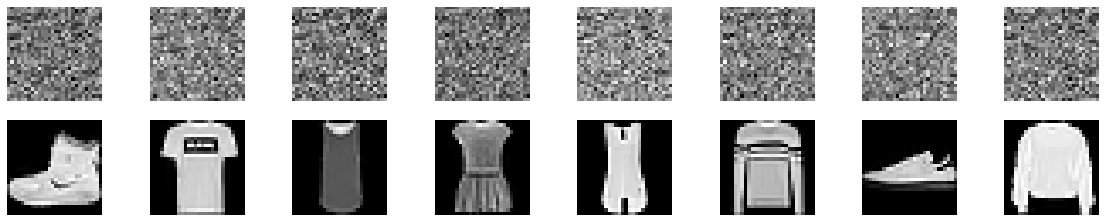

In [0]:
generate_and_plot(generator)

Iter 7900 (404)
(Avg 0.2527046203613281 seconds per iteration)
0.25095560774207115


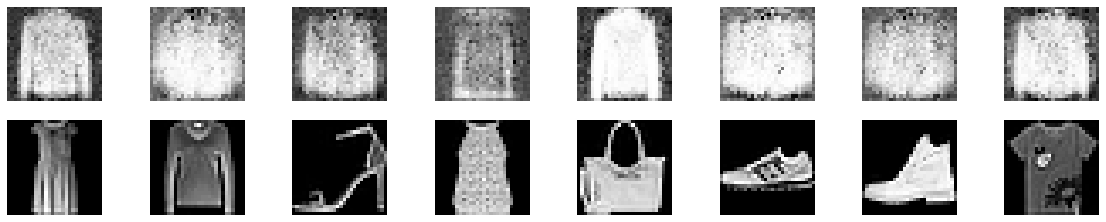

In [0]:
def training(iter=2, batch_size=128):

    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    print(gan.summary())
    start_time = time.time()

    for my_iter in range(iter):

      #Loading the data
      real_iter = my_iter % (len(x_train)//batch_size)
      
      real_data = x_train[real_iter*batch_size:(real_iter+1)*batch_size].reshape(-1, original_dim)

      noise = np.random.normal(0, 1, [batch_size, seed_dim])
      generated_images = generator.predict(noise)

      #Construct different batches of  real and fake data 
      X= np.concatenate([real_data, generated_images])
      
      # Labels for generated and real data
      y_dis=np.zeros(2*batch_size)
      y_dis[:batch_size]=0.9
      
      #Pre train discriminator on  fake and real data  before starting the gan. 
      discriminator.trainable=True
      discriminator.train_on_batch(X, y_dis)

      noise= np.random.normal(0,1, [batch_size, seed_dim])
      y_gen = np.ones(batch_size)
      
      # During the training of gan, 
      # the weights of discriminator should be fixed. 
      #We can enforce that by setting the trainable flag
      discriminator.trainable=False
      
      #training  the GAN by alternating the training of the Discriminator 
      #and training the chained GAN model with Discriminator’s weights freezed.
      gan.train_on_batch(noise, y_gen)
      
      if my_iter % 100 == 0:
        clear_output()
        print(f"Iter {my_iter} ({real_iter})")
        if start_time is not None:
          time_spent = time.time() - start_time
          print(f"(Avg {time_spent/100} seconds per iteration)")
        start_time = time.time()
        print(discriminator.evaluate(X, y_dis, verbose=0))
        generate_and_plot(generator, real_data)
    
training(10000, 64)